In [1]:
import pandas as pd
from my_functions import *

In [2]:
dataset = pd.read_csv('fraud_credit_card.csv')

dataset = dataset.drop(columns=['id']) #remove the id column

# dataset.info() # No need to preprocess missings

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
    print(f"GPU : {device_name}")
else:
    # The dataset is too big so we take only 20% to train the GAN on CPU
    print("No GPU, we'll take only 40% of the dataset to train the GAN")
    dataset = dataset.sample(frac=0.4, random_state=3)

No GPU, we'll take only 40% of the dataset to train the GAN


In [3]:
# Normalization to let the model converge faster (because I tried without and it's too long)
from sklearn.preprocessing import RobustScaler
# We don't normalize the target column
target = dataset['Class'].copy()
dataset = dataset.drop(columns=['Class'])

# Normalization
scaler = RobustScaler()
normalized_data = scaler.fit_transform(dataset)
normalized_data = pd.DataFrame(normalized_data, columns=dataset.columns)

# re-Add the target column
normalized_data['Class'] = target.values

# renommer le dataset 
dataset_processed = normalized_data

In [4]:
noise_matrix = generate_noise(10, dataset_processed.shape[1])

In [13]:
lat_dim = dataset_processed.shape[1]
print(f'Latent dim : {lat_dim}')

generator = define_generator(latent_dim=lat_dim, add_layer=False, alpha=0.2, n_outputs=lat_dim)
discriminator = define_discriminator(n_inputs=lat_dim, add_layer=False, alpha=0.2)

gan = define_gan(generator, discriminator, loss='binary_crossentropy', lr=0.005, beta_1=0.5)

Latent dim : 30


1/1 [==============================] - 0s 27ms/step
E:0, Discriminator Loss: 0.6023126244544983, Generator Loss: 0.5266525745391846
1/1 [==============================] - 0s 19ms/step
E:50, Discriminator Loss: 0.4880356788635254, Generator Loss: 0.6722134947776794
1/1 [==============================] - 0s 18ms/step
E:100, Discriminator Loss: 0.6179553270339966, Generator Loss: 0.5428224205970764
1/1 [==============================] - 0s 19ms/step
E:150, Discriminator Loss: 0.6036605834960938, Generator Loss: 0.519822359085083
1/1 [==============================] - 0s 21ms/step
E:200, Discriminator Loss: 0.5212740898132324, Generator Loss: 0.4292293190956116
1/1 [==============================] - 0s 24ms/step
E:250, Discriminator Loss: 0.3855384588241577, Generator Loss: 0.3595936894416809
1/1 [==============================] - 0s 22ms/step
E:300, Discriminator Loss: 0.34073299169540405, Generator Loss: 0.3904780149459839
1/1 [==============================] - 0s 21ms/step
E:350, Discri

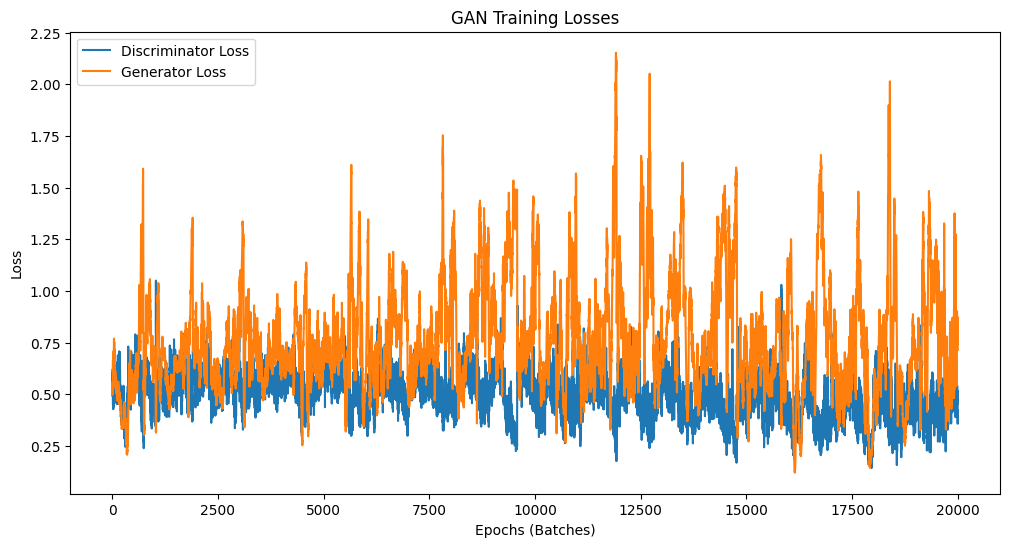

(0.419891357421875, 0.7144237756729126)

In [15]:
train_gan(generator, discriminator, gan, dataset_processed, dataset_processed.shape[1], epochs=20000)

In [16]:
# Génerer des données synthétiques avec le GAN pour tester la qualité des données

noise_matrix = generate_noise(50, lat_dim)
noise_matrix.shape
generated_data = generator.predict(noise_matrix)
generated_data[6][29] # on regarde si la classe est 0 ou 1 (ou proche)

# retirer la dernière colonne et appliquer l'inverse du scaler
class_column = generated_data[:, -1]
generated_data = generated_data[:, :-1]

# appy la normalisation inverse
generated_data = pd.DataFrame(scaler.inverse_transform(generated_data), columns=dataset_processed.columns[:-1])
generated_data['Class'] = class_column


2/2 [==============================] - 0s 3ms/step


In [19]:
# generated_data['Amount'].describe()

original_stats = dataset_processed.describe()
generated_stats = generated_data.describe()
original_stats
# Le GAN a réussi à trouver une valeur pour laquelle ça fonctionnait particulièrement bien donc le générateur ne sait générer que ce type de données

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227452.000000,227452.000000,227452.000000,227452.000000,227452.000000,227452.000000,2.274520e+05,227452.000000,2.274520e+05,2.274520e+05,...,2.274520e+05,227452.000000,2.274520e+05,227452.000000,2.274520e+05,227452.000000,2.274520e+05,2.274520e+05,2.274520e+05,227452.000000
mean,0.066743,0.162550,0.000202,0.054496,-0.111223,-0.084794,-2.874471e-01,0.487533,-8.027575e-02,-2.214447e-01,...,1.178682e-01,0.028081,1.466899e-01,-0.011897,8.012219e-03,0.011205,2.698728e-01,1.984887e-02,8.933972e-04,0.499943
std,0.716149,1.205636,0.783096,0.734229,1.355601,1.060804,1.168420e+00,4.132336,8.859021e-01,8.461801e-01,...,3.130471e+00,1.039499,2.498426e+00,0.739555,9.048733e-01,0.763221,1.540049e+00,1.554531e+00,5.778839e-01,0.500001
min,-2.442034,-60.215261,-2.041464,-3.583765,-5.490440,-22.574114,-5.667185e+00,-44.307608,-3.412977e+00,-2.900873e+00,...,-6.145269e+01,-7.151226,-5.866763e+01,-3.009843,-1.061202e+01,-6.260609,-9.290156e+00,-3.304382e+01,-1.002685e+00,0.000000
25%,-0.339533,-0.423672,-0.507171,-0.427322,-0.512800,-0.555465,-6.385137e-01,-0.323912,-5.839820e-01,-7.209399e-01,...,-4.090410e-01,-0.486241,-4.531672e-01,-0.494064,-4.936443e-01,-0.472212,-2.083341e-01,-3.416783e-01,-4.981342e-01,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.715411e-17,0.000000,-6.163859e-18,-2.350029e-17,...,-1.102117e-17,0.000000,8.838789e-18,0.000000,7.877406e-19,0.000000,-2.173825e-17,-1.356312e-18,-7.604323e-17,0.000000
75%,0.660467,0.576328,0.492829,0.572678,0.487200,0.444535,3.614863e-01,0.676088,4.160180e-01,2.790601e-01,...,5.909590e-01,0.513759,5.468328e-01,0.505936,5.063557e-01,0.527788,7.916659e-01,6.583217e-01,5.018658e-01,1.000000
max,1.661048,5.434499,3.483537,2.409829,58.167690,8.107341,4.034286e+01,25.280584,1.062922e+01,1.454809e+01,...,2.580755e+01,13.284695,6.687911e+01,8.111791,9.193163e+00,4.299380,3.742509e+01,1.208363e+02,1.003137e+00,1.000000


In [20]:
generated_stats

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.762578,-0.619923,1.182618,-0.043798,-0.249740,0.833732,0.413648,-0.092676,-0.913585,1.137116,...,-0.012127,-0.227279,0.090349,-0.421772,-0.659262,-0.961749,-0.139684,-0.130212,4564.504883,0.245388
std,0.679091,0.398155,0.010707,0.569909,0.304178,0.119342,0.110403,0.076965,0.231761,0.072729,...,0.148226,0.305618,0.118305,0.881940,0.328979,0.631601,0.052684,0.184797,8694.631836,0.029143
min,-1.411873,-0.937359,1.163517,-1.435843,-0.483787,0.574491,0.252323,-0.138032,-1.014928,0.729218,...,-0.351950,-0.618848,-0.030118,-1.335055,-1.109562,-1.327268,-0.232074,-0.645783,82.685036,0.180627
25%,0.701002,-0.866539,1.174290,-0.070300,-0.408306,0.766723,0.361704,-0.132460,-0.984731,1.140208,...,-0.008466,-0.343715,0.016992,-1.219897,-0.901139,-1.324117,-0.174054,-0.140830,102.080788,0.227798
50%,1.089311,-0.793446,1.182595,0.283667,-0.362469,0.831828,0.407077,-0.126987,-0.972376,1.153708,...,0.055096,-0.277334,0.044414,-0.577849,-0.658695,-1.255997,-0.149261,-0.077241,182.829575,0.245370
75%,1.191586,-0.585233,1.188073,0.301636,-0.309670,0.909391,0.421735,-0.115209,-0.952730,1.168711,...,0.077082,-0.224657,0.088021,0.220643,-0.481564,-0.998650,-0.109718,-0.025836,1457.220215,0.260113
max,1.275682,0.673237,1.219863,0.323104,0.782819,1.019742,0.844137,0.125338,0.485859,1.201969,...,0.111515,0.855906,0.332181,1.243851,0.041468,0.870233,0.009006,0.089418,24002.414062,0.317851


# Informations :
That's totally normal if the discriminator loss is low at the beginning because he can recognize easily the fake data (the fake transactions) because the generator produces bad data at the beginning.

But as the generator gets better, the discriminator will have a harder time to recognize the fake data and the loss will increase.

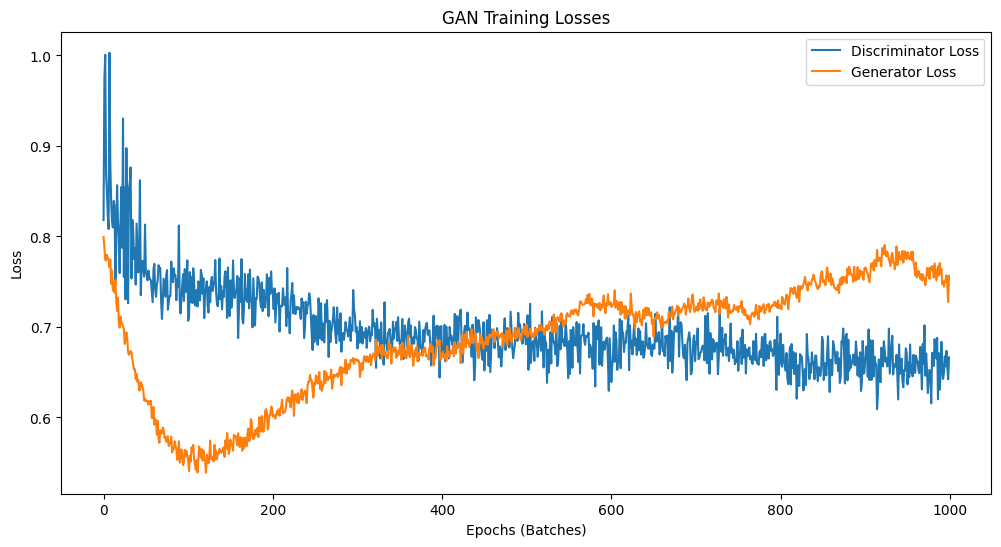

If the discriminator gets too good, the generator will not be able to learn anymore because the discriminator will always recognize the fake data.

If the generator knows how to fake, he will produce a lot of data not recognized by the discriminator (it's called Mode Collapse). The generator don't cover all the data diversity.

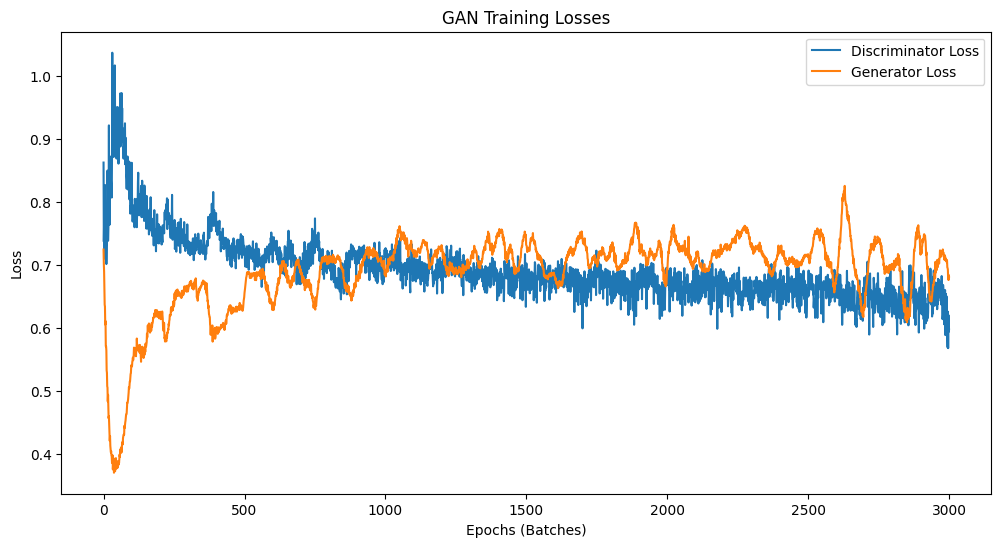

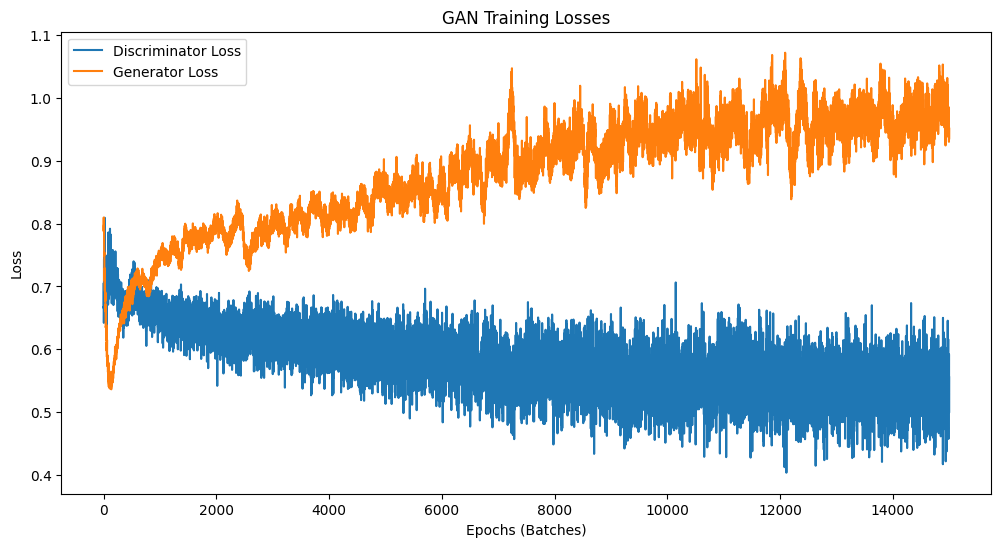

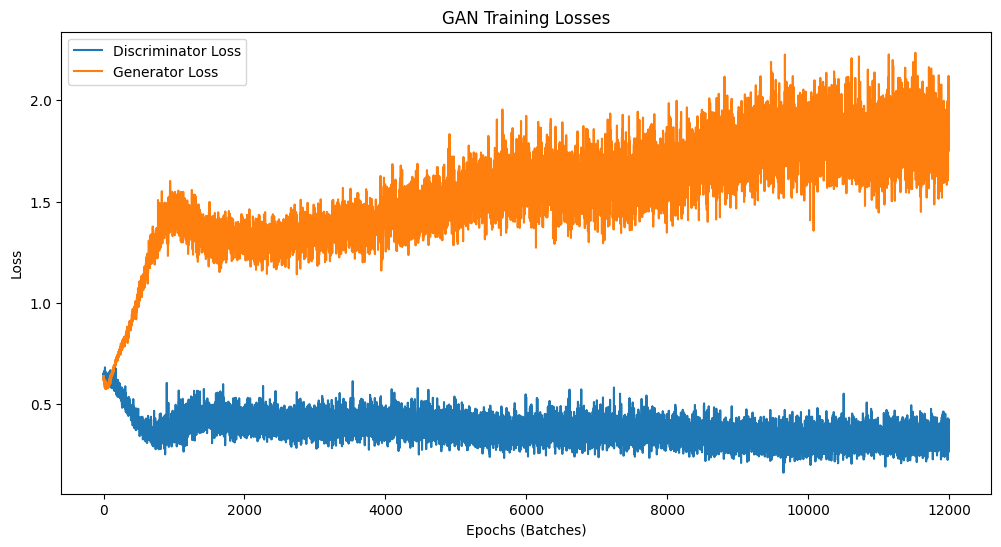

The images just above shows some problems that can occur during the training of a GAN. The first one is the mode collapse, the second one is the vanishing gradient and the last one is the exploding gradient.

### And finally, the last image shows the ideal situation where the generator and the discriminator are both learning and improving. We can see "a fight" between the two networks. The generator tries to produce data that the discriminator can't recognize and the discriminator tries to recognize the fake data.

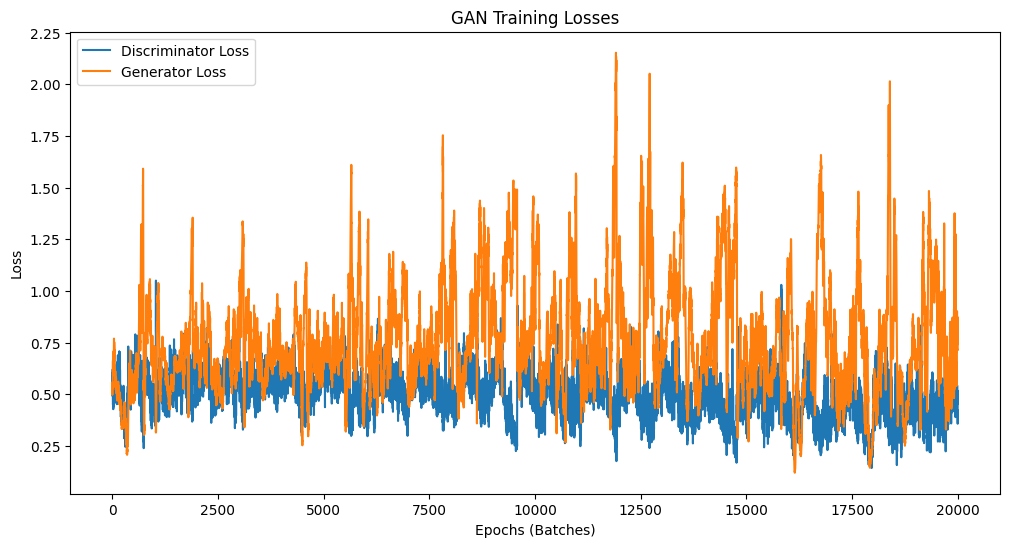

# To continue : 

- hyperparameters to tune
- the architecture of the generator and the discriminator
- the 'Class' of the fraud to set as a bool (make a cGAN ?)